## Names: Somya Singhal(ss5348), Vishal Anand(va2361)

## COMS 4995 HW2

##  Python version used - 3.6

## Pytorch

In [1]:
import torch
import numpy as np
import pickle
import copy
get_ipython().run_line_magic('matplotlib', 'inline')
import matplotlib.pyplot as plt

from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

def unpickle(file):
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict

def load_train_data():
    X_train = None
    Y_train = None
    for i in range(1, 6):
        pickleFile = unpickle('cifar-10-batches-py/data_batch_{}'.format(i))
        dataX = pickleFile[b'data']
        dataY = pickleFile[b'labels']
        if type(X_train) is np.ndarray:
            X_train = np.concatenate((X_train, dataX))
            Y_train = np.concatenate((Y_train, dataY))
        else:
            X_train = dataX
            Y_train = dataY

    Y_train = Y_train.reshape(Y_train.shape[0], 1)

    return X_train.T, Y_train.T

def load_test_data():
    X_test = None
    Y_test = None
    pickleFile = unpickle('cifar-10-batches-py/test_batch')
    dataX = pickleFile[b'data']
    dataY = pickleFile[b'labels']
    if type(X_test) is np.ndarray:
        X_test = np.concatenate((X_test, dataX))
        Y_test = np.concatenate((Y_test, dataY))
    else:
        X_test = np.array(dataX)
        Y_test = np.array(dataY)

    Y_test = Y_test.reshape(Y_test.shape[0], 1)

    return X_test.T, Y_test.T

def train_test_split(X_train, Y_train):
    msk = np.random.rand(Y_train.shape[1]) < 0.8
    X_Train = X_train[:,msk]  
    X_val = X_train[:,~msk]
    Y_Train = Y_train[:,msk]  
    Y_val = Y_train[:,~msk]

    return X_Train, Y_Train, X_val, Y_val

def get_batch(X, Y, batch_size):
    n_batches = int(Y.shape[1]/batch_size)
    idx = np.arange(Y.shape[1])
    np.random.shuffle(idx)
    
    ret = []
    for i in range(0,int(len(idx)/batch_size)):
        chunk = idx[i*batch_size:(i+1)*batch_size]
        ret.append(chunk)
    mini = ret
    
    return mini

In [2]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.pool = nn.MaxPool2d(2, 2)
        self.conv1 = nn.Conv2d(3, 64, 3)
        self.conv2 = nn.Conv2d(64, 128, 3)
        self.conv2_drop = nn.Dropout2d(0.25)
        self.conv3 = nn.Conv2d(128, 256, 3)
        self.conv4 = nn.Conv2d(256,256,3)
        self.fc1 = nn.Linear(256 * 5 * 5, 512)
        self.fc2 = nn.Linear(512, 10)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool(F.relu(self.conv2(x)))
        x = F.dropout(x, training=self.training)
        x = F.relu(self.conv3(x))
        x = self.pool(F.relu(self.conv4(x)))
        x = F.dropout(x, training=self.training)
        x = x.view(-1, 256 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return x

In [3]:
X_train,Y_train = load_train_data()
X_test, Y_test = load_test_data()
X_Train, Y_Train, X_Val, Y_Val = train_test_split(X_train,Y_train)

minn = np.min(X_Train, axis=1,keepdims=True)
maxx = np.max(X_Train, axis=1,keepdims=True)
X_Train= (X_Train - minn)/(maxx-minn)
X_Val= (X_Val - minn)/(maxx-minn)
X_Test= (X_test - minn)/(maxx-minn)

net = Net().cuda()
criterion = nn.CrossEntropyLoss()
optimizer = optim.RMSprop(net.parameters(), lr=0.0003)#, momentum=0.9)
#optimizer = optim.RMSprop(net.parameters(), lr=0.0003, weight_decay=1e-6)#, momentum=0.9)

def test_acc():
    correct = 0
    total = 0
    idx = get_batch(X_Test, Y_test, batch_size_len)

    for idx_list in idx:
        x_batch_test = [X_Test.T[index] for index in idx_list]
        y_batch_test = [Y_test.T[index] for index in idx_list]
        x_batch_test = np.asarray(x_batch_test)
        y_batch_test1 = np.asarray(y_batch_test)
        y_batch_onehot_test = get_one_hot(y_batch_test1,10)
        label_tensor_test = torch.from_numpy(y_batch_onehot_test)
        test_labels = Variable(label_tensor_test.cuda()).long()
        true_labels = torch.max(test_labels,1)[1]
        x_batch_test = x_batch_test.reshape(x_batch_test.shape[0],3,32,32)    
        input_tensor_test = torch.from_numpy(x_batch_test)
        images = Variable(input_tensor_test.cuda()).float()
        outputs = net(images)
        ##### loss = criterion(outputs, torch.max(labels, 1)[1])
        _, predicted = torch.max(outputs.data, 1)

        total += labels.size(0)
        correct += (predicted == true_labels.data.long()).sum()
    
    return (100 * correct / total)

def get_one_hot(targets, nb_classes):
    return np.eye(nb_classes)[np.array(targets).reshape(-1)]


In [4]:
trainacc=[]
valacc=[]
traincost = []
valcost = []
epoch_count = 25
num = epoch_count
batch_size_len = 35

train = ""
print("Start", flush=True)
for epoch in range(num):  # loop over the dataset multiple times
    running_loss = 0.0
    running_loss_val = 0.0
    train_accuracy = 0.0
    val_accuracy = 0.0
    correct_train = 0
    total_train = 0
    correct_val = 0
    total_val = 0
    #print(epoch, flush=True)
    abcd_train = get_batch(X_Train, Y_Train,batch_size_len)
    for i, idx in enumerate(abcd_train, 0):
        # get the inputs
        x_batch = [X_Train.T[index] for index in idx]
        y_batch = [Y_Train.T[index] for index in idx]
        x_batch = np.asarray(x_batch)
        y_batch = np.asarray(y_batch)
        y_batch_onehot = get_one_hot(y_batch,10)
        x_batch = x_batch.reshape(x_batch.shape[0],3,32,32)
        input_tensor = torch.from_numpy(x_batch)
        label_tensor = torch.from_numpy(y_batch_onehot)
        inputs = Variable(input_tensor.cuda()).float()
        labels = Variable(label_tensor.cuda()).long()
        true_labels = torch.max(labels,1)[1]
        optimizer.zero_grad()
        outputs = net(inputs)
        loss = criterion(outputs, torch.max(labels, 1)[1])
        loss.backward()
        optimizer.step()

        running_loss += loss.data[0]
        if i % 100 == 99:    # print every 2000 mini-batches
            if(i+1 == 300):
                #print('[%d, %5d] loss: %.3f' % (epoch + 1, i + 1, running_loss / 100), flush=True)
                #train = train + str(epoch + 1) + ", " + str(i + 1) + ", loss=" + str(running_loss / 100) + "; "
                print("Epoch", epoch + 1, "Count:", i + 1, "loss_train:", running_loss/(batch_size_len*1.0), end=' ')
            traincost.append(running_loss / (batch_size_len*1.0))
            running_loss = 0.0
            
        _, predicted_train = torch.max(outputs.data, 1)
        total_train += labels.size(0)
        correct_train += (predicted_train == true_labels.data.long()).sum()
    train_accuracy = 100 * correct_train / (total_train + 0.0001)
        
    abcd = get_batch(X_Val, Y_Val,batch_size_len)
    for i, idx in enumerate(abcd, 0):
        # get the inputs
        x_batch_val = [X_Val.T[index] for index in idx]
        y_batch_val = [Y_Val.T[index] for index in idx]
        x_batch_val = np.asarray(x_batch_val)
        y_batch_val = np.asarray(y_batch_val)
        y_batch_onehot_val = get_one_hot(y_batch_val,10)
        x_batch_val = x_batch_val.reshape(x_batch_val.shape[0],3,32,32)
        input_tensor_val = torch.from_numpy(x_batch_val)
        label_tensor_val = torch.from_numpy(y_batch_onehot_val)
        inputs_val = Variable(input_tensor_val.cuda()).float()
        labels_val = Variable(label_tensor_val.cuda()).long()
        true_labels_val = torch.max(labels_val,1)[1]
        optimizer.zero_grad()
        outputs_val = net(inputs_val)
        loss_val = criterion(outputs_val, torch.max(labels_val, 1)[1])
        running_loss_val += loss_val.data[0]
        if i == len(abcd) - 1:  
            print("\t", i, "loss_val:", running_loss_val/(batch_size_len*1.0))
            valcost.append(running_loss_val/(batch_size_len*1.0))
            running_loss_val = 0.0
        
        _, predicted_val = torch.max(outputs_val.data, 1)
        total_val += labels_val.size(0)
        correct_val += (predicted_val == true_labels_val.data.long()).sum()
    val_accuracy = 100 * correct_val / total_val
    trainacc.append(train_accuracy)
    valacc.append(val_accuracy)

Start
Epoch 1 Count: 300 loss_train: 5.376365368706839 	 286 loss_val: 11.507724947588784
Epoch 2 Count: 300 loss_train: 3.7381105422973633 	 286 loss_val: 9.570558452606202
Epoch 3 Count: 300 loss_train: 3.151322327341352 	 286 loss_val: 8.504560548918588
Epoch 4 Count: 300 loss_train: 2.7512869008949825 	 286 loss_val: 7.706478461197444
Epoch 5 Count: 300 loss_train: 2.4370549355234417 	 286 loss_val: 6.967035657167434
Epoch 6 Count: 300 loss_train: 2.218562436103821 	 286 loss_val: 6.734426982062203
Epoch 7 Count: 300 loss_train: 1.9200084303106582 	 286 loss_val: 6.364285386460168
Epoch 8 Count: 300 loss_train: 1.8559950504984175 	 286 loss_val: 6.533313021489552
Epoch 9 Count: 300 loss_train: 1.7187585949897766 	 286 loss_val: 6.233361379589353
Epoch 10 Count: 300 loss_train: 1.6397855307374682 	 286 loss_val: 6.089620235988072
Epoch 11 Count: 300 loss_train: 1.5054437675646373 	 286 loss_val: 5.992602858798844
Epoch 12 Count: 300 loss_train: 1.4239475637674333 	 286 loss_val: 5.8

In [5]:
print('Final Training accuracy',trainacc[len(trainacc)-1])
print('Final Validation accuracy',valacc[len(valacc)-1])

Final Training accuracy 89.32014501234471
Final Validation accuracy 78.21801891488303


In [6]:
print('Finished Training', flush=True)
print('Training Accuracy ',trainacc, flush=True)
print('validation Accuracy',valacc, flush=True)

Finished Training
Training Accuracy  [38.41492415571573, 54.476023401837935, 61.883059817495784, 67.31438570849033, 70.92024522118382, 73.54951778252281, 75.47765099417141, 77.29810923426041, 78.77300593771628, 80.24539857206612, 81.19444076325419, 82.47652414554521, 83.20270418629597, 84.03906326771238, 84.755227032039, 85.4563663817294, 86.09239993466284, 86.76349045508078, 87.09653164618372, 87.79266285766205, 87.9103541056458, 88.44372082523171, 88.69162366672938, 89.37773860178356, 89.32014501234471]
validation Accuracy [49.00945744151319, 58.91488302638128, 63.7332005973121, 66.22200099552016, 70.16426082628173, 71.81682429069188, 73.37979094076655, 72.70283723245396, 74.37531110004977, 74.92284718765555, 75.7093081134893, 75.62966650074664, 76.00796416127426, 76.66500746640119, 76.53558984569437, 76.42608262817322, 78.07864609258337, 77.20258835241414, 77.18267794922848, 75.55002488800399, 78.1483325037332, 78.24788451966153, 77.88949726231957, 78.16824290691886, 78.218018914883

In [7]:
Test_accuracy = test_acc()

In [9]:
print("Test:", Test_accuracy, flush=True)

Test: 77.734335839599


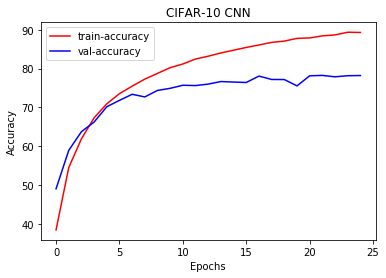

In [19]:
plt.figure()
plt.plot(trainacc, 'r', label ='train-accuracy')
plt.plot(valacc, 'b', label = 'val-accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('CIFAR-10 CNN')
plt.legend()
plt.savefig("1.2accuracy.png")

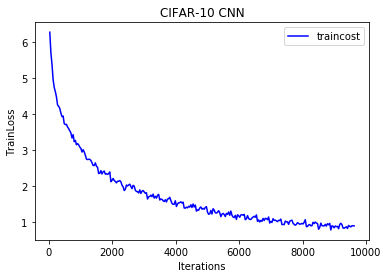

In [20]:
x_t = []


for i in range(len(traincost)):
    x_t.append((i+1)*batch_size_len)

plt.figure()
plt.plot(x_t,traincost, 'b', label = 'traincost')
plt.xlabel('Iterations')
plt.ylabel('TrainLoss')
plt.title('CIFAR-10 CNN')
plt.legend()
plt.savefig("1.2trainloss.png")

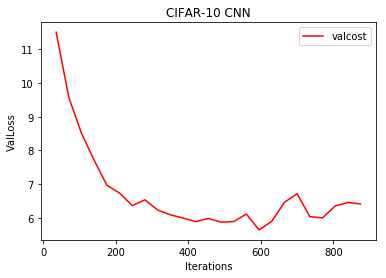

In [21]:
x_v = []
for i in range(len(valcost)):
    x_v.append((i+1)*batch_size_len)
    
plt.figure()
plt.plot(x_v,valcost, 'r', label = 'valcost')
plt.xlabel('Iterations')
plt.ylabel('ValLoss')
plt.title('CIFAR-10 CNN')
plt.legend()
plt.savefig("1.2valloss.png")

In [5]:
print(Net())

NameError: name 'Net' is not defined